Enter your region to get started
Type in one of the following regions or else the program wont work correctly:

na1 or EUW 

Silhouette Score:  0.30969637463711486


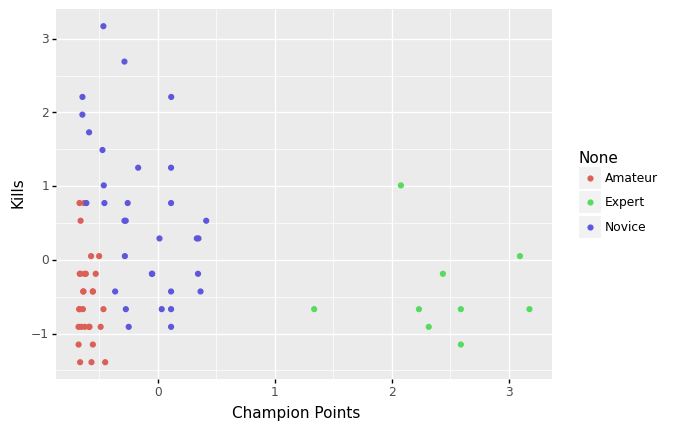

<ggplot: (-9223372036542632872)>


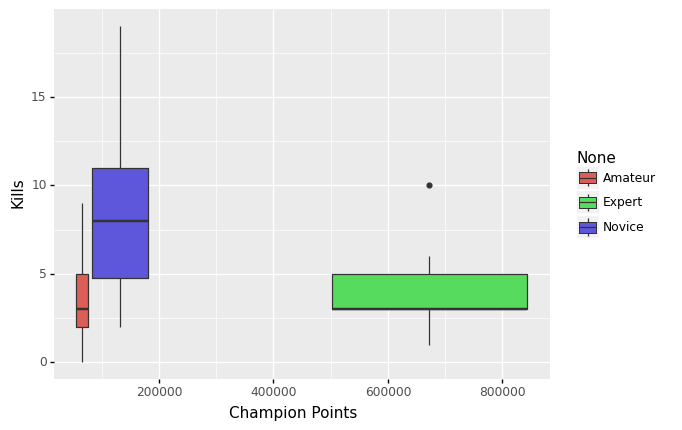

<ggplot: (312142919)>


In [6]:
import requests
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

VisionScores = []
WinLoss = []
GameIDs = []
Kills = []
ChampionID = []
ChampPoints = []
playerID = []
inhibKills =[]
towerKills =[]
dragonKills =[]
baronKills = []
riftKills = []
Cluster1 = []

matchesPulling = 7
    
def requestSummonerData(region, summonerName, APIKey):

    #Create URL and return json file
    
    URL = "https://" + region + ".api.riotgames.com/lol/summoner/v4/summoners/by-name/" + summonerName + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def requestRankedData(region, ID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/league/v4/entries/by-summoner/" + ID + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()
    
def requestMatchHistory(region, ID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/match/v4/matchlists/by-account/" + ID + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def matchIDs(JSON):
    numGames = JSON['endIndex']-JSON['startIndex']
    for x in range(numGames):
        GameIDs.append(JSON['matches'][x]['gameId'])
    return GameIDs

def returnAccInfo(ID, encID, accID, puuid):
    print("ID: ", ID)
    print("EncID: " ,encID)
    print("AccountID: " , accID)
    print("Puuid: " , puuid)
    responseJSON2 = requestRankedData(region, encID, APIKey)
    print("tier: " + responseJSON2[0]['tier'])
    print("rank: " + responseJSON2[0]['rank'])
    print("league points: " + str(responseJSON2[0]['leaguePoints']))

def requestMatchData(region, matchID, APIKey):
    URL = "https://" + region + ".api.riotgames.com/lol/match/v4/matches/" + str(matchID) + "?api_key=" + APIKey
    response = requests.get(URL)
    return response.json()

def returnScores(JSON):
    for x in range(10):
        Kills.append(JSON['participants'][x]['stats']['kills'])
        playerID.append(JSON['participantIdentities'][x]['player']['summonerId'])
        ChampionID.append(JSON['participants'][x]['championId'])
        WinLoss.append(JSON['participants'][x]['stats']['win'])
        
def championData(region, APIKey, ID, champID):
    URL = "https://" + region + ".api.riotgames.com/lol/champion-mastery/v4/champion-masteries/by-summoner/" + str(ID) + "/by-champion/"+ str(champID) + "?api_key=" + APIKey
    response = requests.get(URL)
    ChampPoints.append(response.json()['championPoints'])
    
    return

def main():
    print("Enter your region to get started")
    print("Type in one of the following regions or else the program wont work correctly:\n")
    print("na1 or EUW \n")

    #Ask the user for three things, their region, summoner name, and API Key.

    region = "na1"
    #region = (str)(input('Type in one of the regions above: '))
    summonerName = "OGPoonSlayer"
    #summonerName = (str)(input('Type your Summoner Name here and DO NOT INCLUDE ANY SPACES: '))
    APIKey = "RGAPI-659c5b06-188b-42e1-8d47-b7970b5d91ab"
    #APIKey = (str)(input('Copy and paste your API Key here: '))

    #Input variables into function
    responseJSON  = requestSummonerData(region, summonerName, APIKey)
    
    ID = str(responseJSON['name'])
    encID = str(responseJSON['id'])
    accID = str(responseJSON['accountId'])
    puuid = str(responseJSON['puuid'])
    
    responseJSON1 = requestMatchHistory(region, accID, APIKey)
    
    matchHistory = []
    
    matchHistory = matchIDs(responseJSON1)
    
    for x in range(matchesPulling):
        JSON = requestMatchData(region, matchHistory[x], APIKey)
        returnScores(JSON)
        
    for x in range(matchesPulling*10):
        championData(region, APIKey, playerID[x], ChampionID[x])
    
    df = pd.DataFrame({"Champion Points" : ChampPoints, "Kills" : Kills, "Wins" : WinLoss})
    
    features = ['Champion Points','Kills']
    X = df[features]
    
    z = StandardScaler()
    
    X[features] = z.fit_transform(X)
    
    EM = GaussianMixture(n_components = 3)
    
    EM.fit(X)
    cluster = EM.predict(X)
    
    print("Silhouette Score: ", silhouette_score(X, cluster))
    
    for x in range(len(cluster)):
        if cluster[x] == 0:
            Cluster1.append("Amateur")
        elif cluster[x] == 1:
            Cluster1.append("Novice")
        elif cluster[x] == 2:
            Cluster1.append("Expert")
            
    X['Cluster'] = Cluster1
            
    print(ggplot(X, aes(x = "Champion Points", y = "Kills", color = Cluster1)) +geom_point())
    
    print(ggplot(df, aes(x = 'Champion Points', y = 'Kills', fill = Cluster1)) + geom_boxplot())

if __name__ == "__main__":
    main()



2. Does an individual’s champion points affect how many kills an individual gets in a game?

I changed the question from what it was originally because to do clustering I needed to compare two continuous variables. Wins was a nominal variable which wouldn't work. 

I would say champion points does not affect how many kills an individual gets in a game. Champion points reflect how much experience an individual has on a champion. The graphs tell me that individuals with low or high champion points can either get high kill amounts or low kill amounts. All 3 clusters sit in the same range and there aren't significant differences looking left to right. This means that kills is not really dependent on champion points. However, my boxplot shows a much bigger range in kills for individuals with more champion points. The difference in kills is there between the groups, but as I said earlier I don't think it is significant enough. 